<a href="https://colab.research.google.com/github/RaghuvamsiImadabattuni/Raghu-vamsi_INFO5731_Fall2021/blob/main/In_class_exercise_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (40 points in total, 10/20/2021)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (15 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
#Downloading stopwords
import nltk; nltk.download('stopwords')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 12.1 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=7cbb3e8f0f6469b8e217922197bee269be09865b99fc43cc90e169891446ee9f
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [3]:
pip install spacy

In [4]:
#importing Packages
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [5]:
#Preparing NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [6]:
# Importing Dataset
df = pd.read_csv('/content/Emotion_final.csv')

df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [7]:
# Converting to list
data = df.Text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['i didnt feel humiliated']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['didnt', 'feel', 'humiliated']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['didnt', 'feel', 'humiliated']


In [10]:
# Defining functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['feel', 'humiliate']]


In [12]:
# Creating Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('feel', 1), ('humiliate', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.142*"go" + 0.094*"feeling" + 0.047*"first" + 0.046*"sad" + 0.031*"home" + '
  '0.027*"let" + 0.016*"accept" + 0.015*"listen" + 0.014*"mournful" + '
  '0.013*"pleased"'),
 (1,
  '0.172*"look" + 0.090*"see" + 0.036*"agitate" + 0.024*"hear" + 0.024*"read" '
  '+ 0.022*"share" + 0.021*"close" + 0.020*"hope" + 0.018*"enough" + '
  '0.011*"delight"'),
 (2,
  '0.043*"must" + 0.039*"woman" + 0.037*"young" + 0.035*"new" + 0.031*"girl" + '
  '0.025*"public" + 0.022*"appear" + 0.022*"suddenly" + 0.021*"ever" + '
  '0.021*"express"'),
 (3,
  '0.528*"feel" + 0.022*"also" + 0.017*"bit" + 0.014*"happy" + 0.014*"pretty" '
  '+ 0.013*"depressed" + 0.012*"write" + 0.012*"excited" + 0.011*"keep" + '
  '0.008*"cry"'),
 (4,
  '0.200*"be" + 0.070*"day" + 0.031*"today" + 0.020*"agitated" + 0.016*"laugh" '
  '+ 0.014*"raise" + 0.014*"mood" + 0.013*"yesterday" + 0.011*"guess" + '
  '0.011*"simply"'),
 (5,
  '0.100*"think" + 0.064*"thing" + 0.039*"expression" + 0.038*"great" + '
  '0.037*"help" + 0.03

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.608586756899884

Coherence Score:  0.4609490410858955


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.177808 -0.366561       1        1  15.830946
11     0.365370  0.194867       2        1   9.405915
6     -0.018993  0.004515       3        1   4.856027
9     -0.003595  0.004121       4        1   4.853984
14    -0.018744 -0.013964       5        1   4.808093
4     -0.043352  0.008399       6        1   4.659617
12    -0.021736  0.001271       7        1   4.640815
18    -0.021431  0.011062       8        1   4.506573
10    -0.024242  0.003423       9        1   4.492836
0     -0.038975  0.011973      10        1   4.444420
13    -0.033209  0.012163      11        1   4.255426
1     -0.015073  0.015920      12        1   3.995285
19    -0.042356  0.015941      13        1   3.871840
16    -0.039842  0.013761      14        1   3.757053
17    -0.036274  0.012460      15        1   3.720816
5     -0.036419  0.007677      16        1   3.709657
8     -0.029767  0.010055      17        1   3.644914
7     -0.036899  0.017293      18        1   3.598180
15    -0.040106  0.016784      19        1   3.541106
2     -0.042166  0.018840      20        1   3.406497, topic_info=           Term          Freq         Total Category  logprob  loglift
0          feel  14525.000000  14525.000000  Default  30.0000  30.0000
8            be   1616.000000   1616.000000  Default  29.0000  29.0000
298        look   1191.000000   1191.000000  Default  28.0000  28.0000
103         say   1241.000000   1241.000000  Default  27.0000  27.0000
5            go   1097.000000   1097.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
2244      chill     41.282998     42.237938  Topic20  -4.9652   3.3566
2445  difficult     41.107345     42.062285  Topic20  -4.9695   3.3565
2873    useless     39.275147     40.230086  Topic20  -5.0151   3.3555
346   beautiful     38.094043     39.048982  Topic20  -5.0456   3.3547
2569     virgin     34.752666     35.707606  Topic20  -5.1374   3.3524

[639 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
120      16  0.994326         able
957      19  0.984542   absolutely
194      10  0.992582       accept
403      11  0.986288         ache
416       6  0.975940  achievement
...     ...       ...          ...
78        1  0.998077        write
13       11  0.987266        wrong
47        8  0.997001         year
1511      6  0.990557    yesterday
355      20  0.997781        young

[660 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 12, 7, 10, 15, 5, 13, 19, 11, 1, 14, 2, 20, 17, 18, 6, 9, 8, 16, 3])

In [19]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2021-10-23 02:09:06--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  10.2MB/s    in 1.5s    

2021-10-23 02:09:08 (10.2 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [20]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

In [24]:
mallet_path = "/content/mallet-2.0.8/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [25]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('day', 0.11906158357771261),
   ('feel', 0.09648093841642229),
   ('thought', 0.028005865102639298),
   ('sleep', 0.025073313782991203),
   ('wake', 0.024486803519061583),
   ('hour', 0.02258064516129032),
   ('night', 0.022434017595307918),
   ('job', 0.019501466275659823),
   ('afraid', 0.017595307917888565),
   ('cry', 0.017448680351906158)]),
 (11,
  [('feel', 0.22028811524609843),
   ('work', 0.0823829531812725),
   ('kind', 0.03796518607442977),
   ('hurt', 0.026410564225690276),
   ('lonely', 0.016656662665066026),
   ('finally', 0.015156062424969988),
   ('emotional', 0.015156062424969988),
   ('future', 0.014255702280912365),
   ('frustrated', 0.013955582232893157),
   ('embarrassed', 0.013205282112845138)]),
 (6,
  [('feel', 0.12285336856010567),
   ('write', 0.047702920886540434),
   ('read', 0.036400998091883165),
   ('post', 0.030236312931161014),
   ('girl', 0.027447526787024806),
   ('book', 0.02686041391457508),
   ('share', 0.025245853515338323),
   ('blog', 0

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

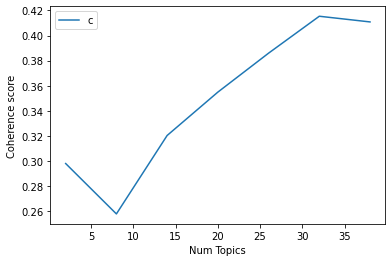

In [28]:
# Showing graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2979
Num Topics = 8  has Coherence Value of 0.2577
Num Topics = 14  has Coherence Value of 0.3203
Num Topics = 20  has Coherence Value of 0.3549
Num Topics = 26  has Coherence Value of 0.3859
Num Topics = 32  has Coherence Value of 0.4154
Num Topics = 38  has Coherence Value of 0.4108


In [30]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.232*"feel" + 0.060*"today" + 0.037*"bad" + 0.031*"child" + 0.031*"post" + '
  '0.025*"blog" + 0.017*"realize" + 0.013*"terrible" + 0.013*"unhappy" + '
  '0.012*"shitty"'),
 (1,
  '0.160*"feel" + 0.115*"day" + 0.025*"sleep" + 0.024*"wake" + 0.024*"move" + '
  '0.024*"change" + 0.023*"weird" + 0.022*"night" + 0.017*"generous" + '
  '0.015*"miserable"'),
 (2,
  '0.109*"feel" + 0.070*"find" + 0.058*"give" + 0.031*"leave" + 0.029*"man" + '
  '0.026*"word" + 0.024*"hear" + 0.024*"show" + 0.017*"mother" + 0.014*"open"'),
 (3,
  '0.242*"feel" + 0.086*"start" + 0.037*"end" + 0.025*"ill" + 0.018*"thankful" '
  '+ 0.017*"totally" + 0.015*"content" + 0.015*"continue" + 0.014*"ignore" + '
  '0.012*"awful"'),
 (4,
  '0.160*"feel" + 0.024*"morning" + 0.024*"eat" + 0.023*"head" + 0.016*"bring" '
  '+ 0.014*"stuff" + 0.013*"food" + 0.012*"expect" + 0.012*"satisfied" + '
  '0.012*"hair"'),
 (5,
  '0.184*"time" + 0.117*"feel" + 0.095*"bit" + 0.039*"long" + 0.035*"home" + '
  '0.027*"spend" + 0.

In [31]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.0673,"make, feel, part, world, guilty, play, set, st...",i didnt feel humiliated
1,1,18.0,0.0804,"feeling, week, remember, anxious, stress, tire...",i can go from feeling so hopeless to so damned...
2,2,4.0,0.0823,"feel, morning, eat, head, bring, stuff, food, ...",im grabbing a minute to post i feel greedy wrong
3,3,2.0,0.0648,"feel, find, give, leave, man, word, hear, show...",i am ever feeling nostalgic about the fireplac...
4,4,0.0,0.0556,"feel, today, bad, child, post, blog, realize, ...",i am feeling grouchy
5,5,10.0,0.0630,"feel, pretty, walk, great, free, low, buy, per...",ive been feeling a little burdened lately wasn...
6,6,5.0,0.0750,"time, feel, bit, long, home, spend, hard, mont...",ive been taking or milligrams or times recomme...
7,7,7.0,0.0804,"people, love, life, feel, care, live, stop, ta...",i feel as confused about life as a teenager or...
8,8,12.0,0.0809,"feel, year, lose, sad, leave, point, miss, ama...",i have been with petronas for years i feel tha...
9,9,16.0,0.0673,"feel, person, kind, lot, begin, watch, reason,...",i feel romantic too


In [32]:
# Grouping top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1331,"feel, today, bad, child, post, blog, realize, ...",i feel as if i havent blogged in ages are at l...
1,1.0,0.1709,"feel, day, sleep, wake, move, change, weird, n...",im off to the big city solo for what im afraid...
2,2.0,0.2675,"feel, find, give, leave, man, word, hear, show...",i feel ignored i feel this boredom like a litt...
3,3.0,0.1407,"feel, start, end, ill, thankful, totally, cont...",im totally digging and all the band business o...
4,4.0,0.1763,"feel, morning, eat, head, bring, stuff, food, ...",i found myself feeling more satisfied after ea...


In [33]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,8.0,"make, feel, part, world, guilty, play, set, st...",1385.0,0.0645
1.0,18.0,"feeling, week, remember, anxious, stress, tire...",1334.0,0.0622
2.0,4.0,"feel, morning, eat, head, bring, stuff, food, ...",1132.0,0.0528
3.0,2.0,"feel, find, give, leave, man, word, hear, show...",1165.0,0.0543
4.0,0.0,"feel, today, bad, child, post, blog, realize, ...",1048.0,0.0488
...,...,...,...,...
21454.0,3.0,"feel, start, end, ill, thankful, totally, cont...",NaN,NaN
21455.0,10.0,"feel, pretty, walk, great, free, low, buy, per...",NaN,NaN
21456.0,6.0,"feel, write, real, sense, strong, strange, saf...",NaN,NaN
21457.0,17.0,"face, run, heart, pain, eye, body, hand, cold,...",NaN,NaN


## (2) (15 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [34]:
#importing modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt





In [93]:
# Importing Dataset
df = pd.read_csv('/content/Emotion_final.csv')

df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [90]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

In [106]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [107]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix
dictionary,doc_term_matrix=prepare_corpus(texts)

In [97]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [98]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [99]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

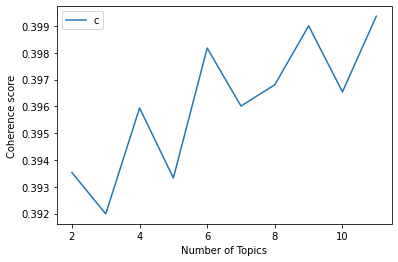

In [101]:
start,stop,step=2,12,1
plot_graph(texts,start,stop,step)

In [103]:
# LSA Model
number_of_topics=7
words=10
document_list,titles=load_data("","/content/Emotion_final.csv")
texts=preprocess_data(document_list)
model=create_gensim_lsa_model(texts,number_of_topics,words)

Total Number of Documents: 21460
[(0, '0.849*"feel" + 0.293*"happi" + 0.241*"sad" + 0.173*"like" + 0.132*"im" + 0.101*"love" + 0.095*"anger" + 0.086*"fear" + 0.051*"get" + 0.050*"time"'), (1, '-0.731*"happi" + 0.668*"sad" + 0.048*"feel" + 0.040*"anger" + 0.035*"fear" + 0.019*"bit" + -0.018*"excit" + -0.014*"content" + 0.014*"hate" + 0.014*"depress"'), (2, '0.562*"sad" + 0.460*"happi" + -0.413*"anger" + -0.359*"love" + -0.308*"fear" + -0.178*"like" + -0.130*"feel" + -0.071*"im" + -0.048*"surpris" + -0.027*"peopl"'), (3, '-0.881*"like" + 0.246*"fear" + -0.244*"love" + 0.202*"anger" + 0.192*"feel" + -0.069*"sad" + 0.052*"im" + -0.037*"realli" + -0.035*"happi" + 0.033*"littl"'), (4, '-0.810*"im" + 0.480*"love" + -0.210*"like" + -0.162*"anger" + 0.137*"feel" + -0.057*"fear" + -0.056*"go" + -0.032*"sure" + -0.028*"ive" + -0.025*"littl"'), (5, '0.634*"love" + 0.530*"im" + -0.474*"anger" + -0.265*"like" + -0.058*"feel" + 0.030*"sad" + -0.027*"get" + -0.025*"would" + 0.025*"support" + -0.024*"i

## (3) (10 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
Coherence Score for LDA model is 0.4609490410858955 and 
coherence score for LSA model is 0.40

From results of above coherences LDA model performed better with the coherence value of 0.4609490410858955 ( with number of topics are 35) which is highest when compared to LSA model with the coherence value of 0.40(with the number of topics are 10)

LDA creates the z matrixes whose rows represent all the words in the data record and whose columns represent all the documents. Each value in the array represents a topic to which the LDA algorithm assigns the word represented by the row and column. which is useful for optimizing.

So, LDA model is better than LSA model



